In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stock_analysis import StockVisualizer, StockReader, StockAnalyzer
from stock_analysis.utils import group_stocks, make_portfolio

In [78]:
start_date = '2014-01-01'
end_date = '2024-01-01'
reader = StockReader(start_date, end_date)

In [79]:
# get FAANG data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

In [80]:
# get S&P 500 data (Market Rate Rm)
sp = reader.get_index_data('S&P 500')

In [90]:
faang = group_stocks(
    {
        'Facebook': fb,
        'Apple': aapl,
        'Amazon': amzn,
        'Netflix': nflx,
        'Google': goog
    }
)

# create faang portfolio
faang_portfolio = make_portfolio(faang)
del faang_portfolio['high']
del faang_portfolio['low']
del faang_portfolio['open']
del faang_portfolio['name']

# calculate and add daily returns
faang_portfolio['daily_return']= faang_portfolio['close'].pct_change()
faang_portfolio.to_csv('portfolio_data/faang_portfolio.csv')
faang_portfolio.tail()

,adj_close,close,volume,daily_return
date,,,,
2023-12-22,1329.643311,1329.890030,99562900,-0.004588
2023-12-26,1335.053986,1335.300003,77089700,0.004068
2023-12-27,1337.303833,1337.549988,112580000,0.001685
2023-12-28,1336.823318,1337.070023,86808700,-0.000359
2023-12-29,1325.994629,1326.239990,115010500,-0.008100


In [82]:
## todo: need to find a suitable rf (use ff maybe)
rf = 0.021  # placeholder for risk-free rate

# examine portfolio returns
faang_analyzer = StockAnalyzer(faang_portfolio)

# CAPM alpha and beta
falpha = faang_analyzer.alpha(sp, rf)
fbeta = faang_analyzer.beta(sp)

print("Alpha (last 10 years): ", falpha)
print("Beta (last 10 years): ", fbeta)

Alpha (last 10 years):  4.736490932174565
Beta (last 10 years):  1.1780521778822866


/Users/joshzheng/Documents/stock-analysis/stock_analysis/stock_analyzer.py:182: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start, end = df.close[0], df.close[-1]


In [83]:
# get Fama French Five Factor Model Data
famafrench = pd.read_csv('famafrench_data/F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3, index_col=0)
famafrench['date'] = pd.to_datetime(df.index, format='%Y%m%d')
famafrench.set_index('date', inplace=True)
famafrench.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2023-12-22,0.21,0.61,0.09,-0.64,0.19,0.021
2023-12-26,0.48,0.81,0.46,-0.34,-0.15,0.021
2023-12-27,0.16,0.16,0.12,-0.31,-0.14,0.021
2023-12-28,-0.01,-0.38,0.03,-0.32,0.15,0.021
2023-12-29,-0.43,-1.13,-0.37,0.67,-0.07,0.021


In [86]:
famafrench.describe().T

,count,mean,std,min,25%,50%,75%,max
Mkt-RF,15229.0,0.027365,1.022344,-17.44,-0.420,0.050,0.500,11.350
SMB,15229.0,0.007092,0.544575,-11.19,-0.280,0.020,0.300,6.170
HML,15229.0,0.014463,0.583114,-5.02,-0.240,0.010,0.250,6.730
RMW,15229.0,0.013806,0.399934,-3.01,-0.170,0.010,0.190,4.510
CMA,15229.0,0.012793,0.378663,-5.87,-0.180,0.010,0.200,2.530
RF,15229.0,0.017232,0.012570,0.00,0.007,0.018,0.024,0.061


In [92]:
# merge the dataframes based on the date index
merged_data = famafrench.join(faang_portfolio['daily_return'], how='inner')
merged_data.to_csv('portfolio_data/merged_data.csv')
merged_data.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF,daily_return
date,,,,,,,
2023-12-22,0.21,0.61,0.09,-0.64,0.19,0.021,-0.004588
2023-12-26,0.48,0.81,0.46,-0.34,-0.15,0.021,0.004068
2023-12-27,0.16,0.16,0.12,-0.31,-0.14,0.021,0.001685
2023-12-28,-0.01,-0.38,0.03,-0.32,0.15,0.021,-0.000359
2023-12-29,-0.43,-1.13,-0.37,0.67,-0.07,0.021,-0.008100


In [98]:
# clean data
merged_data = merged_data.dropna()
print(merged_data.isnull().sum())

Mkt-RF          0
SMB             0
HML             0
RMW             0
CMA             0
RF              0
daily_return    0
dtype: int64


In [108]:
# Step 2: Prepare the data
X = merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)
y = merged_data['daily_return']

# Step 3: Fit the regression model
model = sm.OLS(y, X).fit()

# Step 4: Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           daily_return   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     880.8
Date:                Tue, 13 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:13:35   Log-Likelihood:                 7704.7
No. Observations:                2515   AIC:                        -1.540e+04
Df Residuals:                    2509   BIC:                        -1.536e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.985      0.0

## Data Visualization

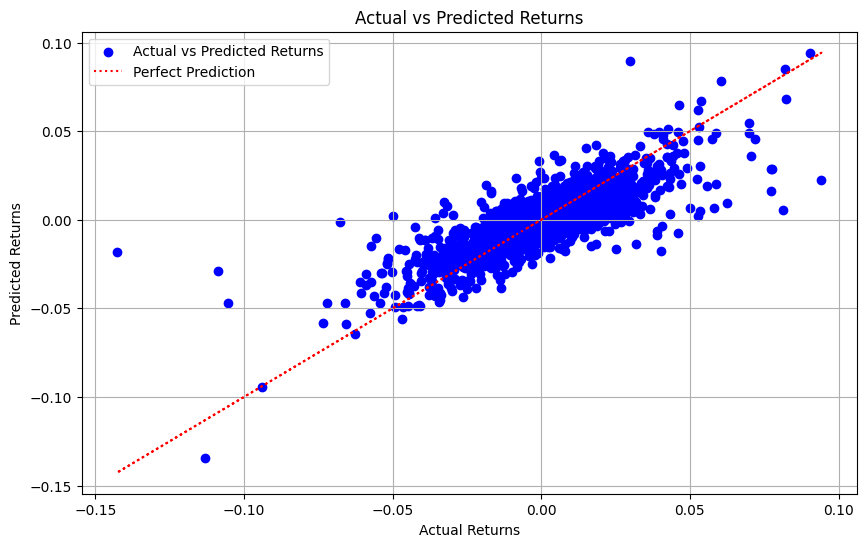

In [110]:
plt.figure(figsize=(10, 6))
plt.scatter(y, model.predict(X), color='blue', label='Actual vs Predicted Returns')
plt.plot(y, y, color='red', linestyle=':', label='Perfect Prediction')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.legend()
plt.grid(True)
plt.show()

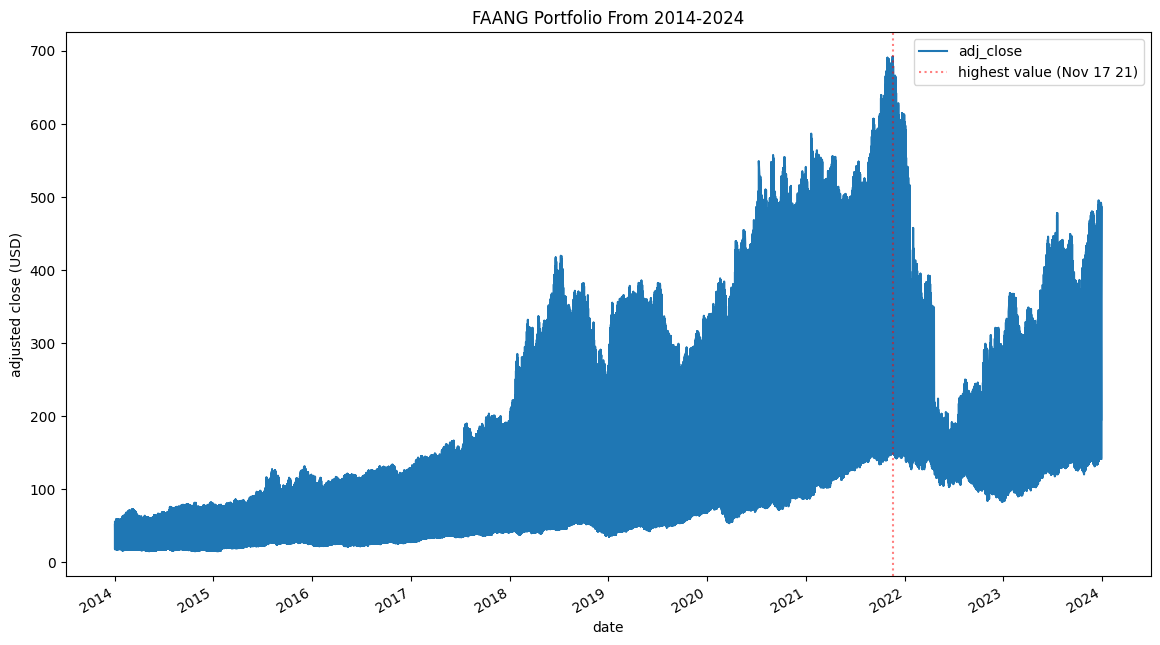

In [85]:
faang_visualizer = StockVisualizer(faang)

fx = faang_visualizer.evolution_over_time(
    'adj_close',
    figsize = (15, 8),
    legend = True,
    title = 'FAANG Portfolio From 2014-2024'
)

faang_visualizer.add_reference_line( 
    fx,
    x = faang_portfolio.high.idxmax(),
    color = 'red',
    linestyle = ':',
    label=f'highest value ({faang.high.idxmax():%b %d %y})',
    alpha = 0.5
)

fx.set_ylabel('adjusted close (USD)')
plt.show()